# Засоби підготовки та аналізу даних
### ФБ-22 Загородній Ярослав
##### Лабораторна робота №5

#### Реалізуйте завдання 1 за допомогою сучасних графічних бібліотек на ваш вибір: Plotly, Bokeh, Altair тощо. Додайте декілька вікон для візуалізації замість одного, спадне меню (drop-down menu) та інші інтерактивні елементи на власний розсуд.

In [57]:
import numpy as np
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import dash
from dash import dcc, html, Input, Output, State

In [66]:
# Задаємо початкові значення параметрів гармоніки та шуму
A_default = 1.0
omega_default = 1.0
phi_default = 0.0
noise_level_default = 0.1
cutoff_frequency_default = 0.05

# Ініціалізація змінних для зберігання даних
t = np.linspace(0, 10, 1000)
noise_cache = None
prev_noise_level = None

# Функція для генерації даних гармоніки з накладеним шумом
def generate_data(A, omega, phi, noise_level):
    global noise_cache, prev_noise_level
    
    # Генеруємо чистий сигнал
    y_clean = A * np.sin(omega * t + phi)
    
    # Перевіряємо, чи змінився рівень шуму
    if noise_cache is None or noise_level != prev_noise_level:
        noise_cache = np.random.normal(0, noise_level, t.shape)
        prev_noise_level = noise_level
    
    # Додаємо шум до сигналу
    y_noisy = y_clean + noise_cache
    return t, y_noisy

# Функція для оновлення графіку при зміні параметрів
def update_graph(A, omega, phi, noise_level):
    t, y = generate_data(A, omega, phi, noise_level)
    trace = go.Scatter(x=t, y=y, mode='lines', name='Noisy Harmonic Function')
    layout = go.Layout(title='Noisy Harmonic Function',
                       xaxis=dict(title='Time'),
                       yaxis=dict(title='Amplitude'))
    return {'data': [trace], 'layout': layout}


In [60]:
# Ініціалізуємо Dash додаток
app = dash.Dash(__name__)

# Створюємо макет інтерфейсу зі слайдерами, кнопкою та графіком
app.layout = html.Div([
    html.H1(style={'color': 'white'}, children=["Interactive Harmonic Function Plot"]),
    dcc.Graph(id='harmonic-graph', style={'width': '80%', 'height': '500px'}),
    html.Label(style={'color': 'white'}, children=["Amplitude (A):"]),
    dcc.Slider(id='amplitude-slider', min=0, max=2, step=0.1, value=A_default),
    html.Label(style={'color': 'white'}, children=["Angular Frequency (omega):"]),
    dcc.Slider(id='omega-slider', min=0, max=2, step=0.1, value=omega_default),
    html.Label(style={'color': 'white'}, children=["Phase (phi):"]),
    dcc.Slider(id='phi-slider', min=0, max=2*np.pi, step=0.1, value=phi_default),
    html.Label(style={'color': 'white'}, children=["Noise Level:"]),
    dcc.Slider(id='noise-slider', min=0, max=1, step=0.1, value=noise_level_default),
    html.Button('Reset', id='reset-button', n_clicks=0),
    dcc.Checklist(
        id='noise-checkbox',
        options=[{'label': 'Виключити шум', 'value': 'disable_noise'}],
        value=[],
        style={'color': 'white'}
    )
])

# Підключаємо зв'язки між інтерфейсом та функціоналом
@app.callback(
    Output('harmonic-graph', 'figure'),
    [Input('amplitude-slider', 'value'),
     Input('omega-slider', 'value'),
     Input('phi-slider', 'value'),
     Input('noise-slider', 'value'),
     Input('reset-button', 'n_clicks'),
     Input('noise-checkbox', 'value')]
)
def update_figure(A, omega, phi, noise_level, n_clicks, noise_checkbox):
    if n_clicks:
        return update_graph(A_default, omega_default, phi_default, noise_level_default)
    elif 'disable_noise' in noise_checkbox:
        return update_graph(A, omega, phi, 0)  # Вимкнути шум, якщо вибрано в чекбоксі
    else:
        return update_graph(A, omega, phi, noise_level)

# Функція для скидання значень слайдерів до початкових
@app.callback(
    [Output('amplitude-slider', 'value'),
     Output('omega-slider', 'value'),
     Output('phi-slider', 'value'),
     Output('noise-slider', 'value'),
     Output('noise-checkbox', 'value')],
    [Input('reset-button', 'n_clicks')]
)
def reset_sliders(n_clicks):
    if n_clicks:
        return A_default, omega_default, phi_default, noise_level_default, []
    else:
        raise dash.exceptions.PreventUpdate

# Запускаємо додаток
if __name__ == '__main__':
    app.run_server(debug=True)


#### Реалізуйте ваш власний фільтр, використовуючи виключно Python (а також numpy, але виключно для операцій з масивами numpy.ndarray). Застосуйте фільтр

In [84]:
def my_filter(signal, cutoff_frequency):
    # Обчислюємо частотну просторову ознаку
    spectrum = np.fft.fft(signal)
    # Визначаємо частоти в частотній просторі
    frequencies = np.fft.fftfreq(len(signal))
    
    # def plot_frequency_spectrum(spectrum, frequencies):
    #     plt.figure(figsize=(10, 6))
    #     plt.plot(frequencies, spectrum)
    #     plt.title('Frequency Spectrum')
    #     plt.xlabel('Frequency (Hz)')
    #     plt.ylabel('Magnitude')
    #     plt.grid(True)
    #     plt.show()

    # plot_frequency_spectrum(spectrum, frequencies)
    
    # Встановлюємо в нуль частоти вище від заданої відсічки
    spectrum[np.abs(frequencies) > cutoff_frequency] = 0
    
    # Залишаємо тільки гармонічні складові, видаляючи шум
    clean_spectrum = np.where(np.abs(frequencies) <= cutoff_frequency, spectrum, 0)
    
    # Перетворюємо назад у часовий домен
    clean_signal = np.fft.ifft(clean_spectrum)
    
    # Повертаємо чистий сигнал та всі потрібні дані
    return np.real(clean_signal)

C:\Users\Ярослав\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning:

Casting complex values to real discards the imaginary part



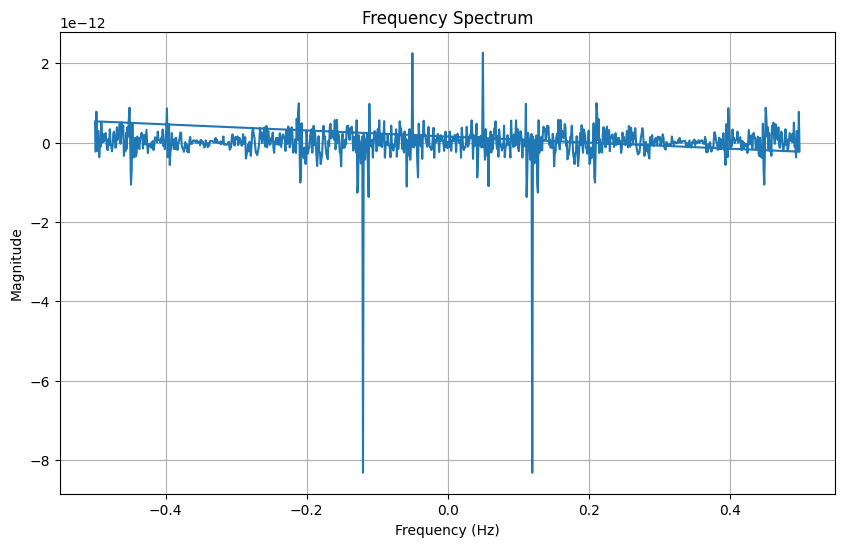

array([ 8.07793567e-31,  6.51290547e-01,  1.08679862e+00,  1.19427362e+00,
        1.01372313e+00,  7.06107374e-01,  4.59912891e-01,  3.86853032e-01,
        4.63440309e-01,  5.49893831e-01,  4.75528258e-01,  1.43396532e-01,
       -4.03722976e-01, -9.93079271e-01, -1.40347004e+00, -1.47552826e+00,
       -1.19193335e+00, -6.84672051e-01, -1.65621290e-01,  1.82126631e-01,
        2.93892626e-01,  2.46350378e-01,  2.02528631e-01,  3.10003630e-01,
        6.08782963e-01,  1.00000000e+00,  1.29333007e+00,  1.30803036e+00,
        9.73041874e-01,  3.71683611e-01, -2.93892626e-01, -8.00160620e-01,
       -1.00994922e+00, -9.33361938e-01, -7.10179679e-01, -5.24471742e-01,
       -4.98642990e-01, -6.24954718e-01, -7.71847529e-01, -7.61430521e-01,
       -4.75528258e-01,  6.81401573e-02,  7.12130196e-01,  1.23118096e+00,
        1.44220014e+00,  1.29389263e+00,  8.88389900e-01,  4.23760373e-01,
        8.87718881e-02, -3.32565586e-02, -2.05705981e-15,  3.32565586e-02,
       -8.87718881e-02, -

In [80]:
fs = 1000  # Частота дискретизації
t = np.linspace(0, 1, fs, endpoint=False)
signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)
my_filter( signal, 100)

In [85]:
# Оновлена функція для оновлення графіку з можливістю застосування фільтра
def update_graph(A, omega, phi, noise_level, cutoff_frequency, apply_filter=False):
    t, y = generate_data(A, omega, phi, noise_level)
    if apply_filter:
        y = my_filter(y, cutoff_frequency)  # Застосовуємо ваш фільтр
    trace = go.Scatter(x=t, y=y, mode='lines', name='Noisy Harmonic Function')
    layout = go.Layout(title='Noisy Harmonic Function',
                       xaxis=dict(title='Time'),
                       yaxis=dict(title='Amplitude'))
    return {'data': [trace], 'layout': layout}

In [87]:
# Ініціалізуємо Dash додаток
app = dash.Dash(__name__)

# Створюємо макет інтерфейсу зі слайдерами, кнопкою та графіком
app.layout = html.Div([
    html.H1(style={'color': 'white'}, children=["Interactive Harmonic Function Plot"]),
    dcc.Graph(id='harmonic-graph', style={'width': '80%', 'height': '500px'}),
    html.Label(style={'color': 'white'}, children=["Amplitude (A):"]),
    dcc.Slider(id='amplitude-slider', min=0, max=2, step=0.1, value=A_default),
    html.Label(style={'color': 'white'}, children=["Angular Frequency (omega):"]),
    dcc.Slider(id='omega-slider', min=0, max=20, step=0.1, value=omega_default),
    html.Label(style={'color': 'white'}, children=["Phase (phi):"]),
    dcc.Slider(id='phi-slider', min=0, max=2*np.pi, step=0.1, value=phi_default),
    html.Label(style={'color': 'white'}, children=["Noise Level:"]),
    dcc.Slider(id='noise-slider', min=0, max=1, step=0.1, value=noise_level_default),
    html.Label(style={'color': 'white'}, children=["Cutoff Frequency:"]),
    dcc.Slider(id='cutoff-frequency-slider', min=0.001, max=0.01, step=0.001, value=cutoff_frequency_default),
    html.Button('Reset', id='reset-button', n_clicks=0),
    dcc.Checklist(
        id='filter-checkbox',
        options=[{'label': 'Використовувати фільтр', 'value': 'apply_filter'}],
        value=[],
        style={'color': 'white'}
    )
])

@app.callback(
    Output('harmonic-graph', 'figure'),
    [Input('amplitude-slider', 'value'),
     Input('omega-slider', 'value'),
     Input('phi-slider', 'value'),
     Input('noise-slider', 'value'),
     Input('cutoff-frequency-slider', 'value'),
     Input('reset-button', 'n_clicks'),
     Input('filter-checkbox', 'value')]
)
def update_figure(A, omega, phi, noise_level, cutoff_frequency, n_clicks, filter_checkbox):
    if n_clicks:
        return update_graph(A_default, omega_default, phi_default, noise_level_default, cutoff_frequency_default)
    else:
        apply_filter = True if 'apply_filter' in filter_checkbox else False
        return update_graph(A, omega, phi, noise_level, cutoff_frequency, apply_filter)

# Функція для скидання значень слайдерів до початкових
@app.callback(
    [Output('amplitude-slider', 'value'),
     Output('omega-slider', 'value'),
     Output('phi-slider', 'value'),
     Output('noise-slider', 'value'),
     Output('cutoff-frequency-slider', 'value')],
    [Input('reset-button', 'n_clicks')]
)
def reset_sliders(n_clicks):
    if n_clicks:
        return A_default, omega_default, phi_default, noise_level_default, cutoff_frequency_default
    else:
        raise dash.exceptions.PreventUpdate

# Запускаємо додаток
if __name__ == '__main__':
    app.run_server(debug=True)